# 1. Extracting building area
*Written by Men Vuthy, 2021*

---

Import modules

In [1]:
import os
import numpy as np
import pandas as pd

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
raster = rasterio.open('image_indo.tiff')

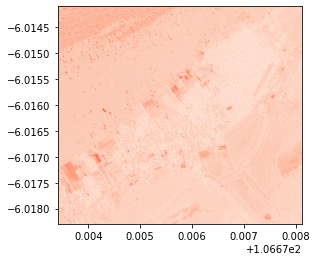

<AxesSubplot:>

In [3]:
# visualize red band
show(raster, 3, cmap = 'Reds')

In [4]:
# Read the grid values into numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

In [5]:
blue.dtype

dtype('uint16')

#### a. Calculate BSI

As for BSI, the difference is clear when the input is not normalized. Therefore, uint16 is being used in this calculation

Create a function to calculate BSI

In [6]:
def get_bsi(red, green, blue):
    # By default numpy will complain about dividing with zero values. 
    # We need to change that behaviour because we have a lot of 0 values in our data.
    np.seterr(divide='ignore', invalid='ignore')
    # BSI formula
    bsi = ((red + blue) - green)/((red + blue) + green)
    return bsi

In [7]:
# Calculate bsi
BSI = get_bsi(red, green, blue)

Visualize BSI in a plot BSI

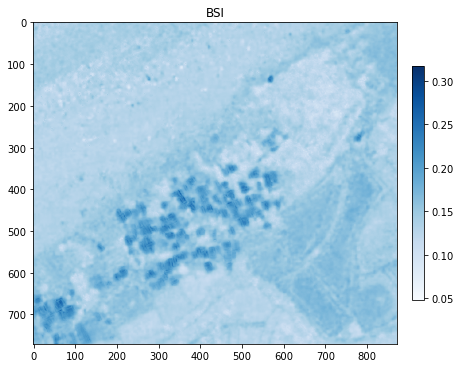

In [8]:
# Plot the BSI
plt.figure(figsize=(7,7))
plt.imshow(BSI, cmap='Blues')

# Add colorbar to show the index
plt.colorbar(fraction=0.03, pad=0.04)
plt.title('BSI')

# plt.savefig('BSI.png', dpi = 150)

plt.show();

Export BSI to GeoTiff

In [9]:
# Data dir
data_dir = "output"

# Output raster
out_tif = os.path.join(data_dir, "BSI.tif")

# Copy the metadata
out_meta = raster.meta.copy()
out_meta

# Update the metadata
out_meta.update({'driver': 'GTiff',
                 'dtype': 'float32',
                 'nodata': None,
                 'width': BSI.shape[1],
                 'height': BSI.shape[0],
                 'crs': raster.crs,
                 'count':1,
                 'transform': raster.transform
                })

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(BSI.astype(np.float32), indexes = 1)

#### b. Extract building area

In [10]:
# Make a copy of above BSI
import copy
building_area = copy.copy(BSI)

# Set Threshold value (it's dependent on area. The value must be manually checked against NRG image in QGIS.)
building_area[BSI<0.18] = np.nan

In [11]:
# Data dir
data_dir = "output"

# Output raster
out_tif = os.path.join(data_dir, "build_area.tif")

# Copy the metadata
out_meta = raster.meta.copy()
out_meta

# Update the metadata
out_meta.update({'driver': 'GTiff',
                 'dtype': 'float32',
                 'nodata': None,
                 'width': building_area.shape[1],
                 'height': building_area.shape[0],
                 'crs': raster.crs,
                 'count':1,
                 'transform': raster.transform
                })

with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(building_area.astype(np.float32), indexes = 1)

#### c. Visualize result

In [12]:
import hvplot
import hvplot.xarray
import geoviews as gv
import xarray as xr

In [13]:
# Load data
image = xr.open_rasterio('image_indo.tiff')
BSI = xr.open_rasterio('output/BSI.tif')
building = xr.open_rasterio('output/build_area.tif')

In [14]:
# Convert datatype from Uint16 to Uint8
dnan = image.where(image>0)
norm = lambda arr : (arr-np.nanmin(arr)) * 255/(np.nanmax(arr)-np.nanmin(arr))
val = np.array([norm(dnan.values[0]), norm(dnan.values[1]), norm(dnan.values[2]), norm(dnan.values[3])])
val = np.where(np.isnan(val), 0, val)
val = val.astype(np.uint8)
dnan.values = val

In [15]:
# Add basemap
geomap = gv.tile_sources.EsriImagery

In [16]:
# Create composite images for natural and false color
natural = geomap *dnan.isel(band=[2,3,1]).hvplot.rgb(x='x',y='y',z='value', bands='band',geo=True, frame_height=400).options(title='natural color')
false = geomap *dnan.isel(band=[3,2,1]).hvplot.rgb(x='x',y='y',z='value', bands='band',geo=True, frame_height=400).options(title='false color')

C:\Users\a9418\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Users\a9418\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [17]:
# visualize vegetation area
building_plot = false * building[0].hvplot.image(x='x',y='y',cmap='gray', geo=True, frame_height=400,clim=(-1,1)).options(title='Building area', clipping_colors={'NaN':'transparent', '-3':'transparent'})
building_plot

C:\Users\a9418\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


:Overlay
   .WMTS.I  :WMTS   [Longitude,Latitude]
   .RGB.I   :RGB   [x,y]   (R,G,B)
   .Image.I :Image   [x,y]   (value)